In [10]:
import glob

import numpy as np
import pandas as pd
from pylab import *
from palettable.colorbrewer.qualitative import Set2_7
import h5py
from pathlib import Path
from domainbed.lib import FFT
from scipy import signal
from scipy.interpolate import interp2d
import scipy.io as scio


In [3]:
colors = Set2_7.mpl_colors

params = {
    'axes.labelsize': 8,
    'font.size': 8,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'text.usetex': False,
    'figure.figsize': [4.5, 4.5]
}
rcParams.update(params)
plt.style.use(['science', 'no-latex', 'cjk-sc-font'])

# Fig 1: 变转速时频、频谱绘制

In [4]:
data_path = Path("D:\datasets\复合故障数据集\数据\Case 1")
file_path = data_path / "B4L.h5"
read_file = h5py.File(file_path, 'r')
signals = pd.DataFrame(np.array(read_file['x']))
read_file.close()
pre_second = 2
sig = signals.iloc[0][2560 * pre_second:2560 * pre_second + 51200 * 2]
sampling_frequency = 5120
nperseg = 255
noverlap = 170

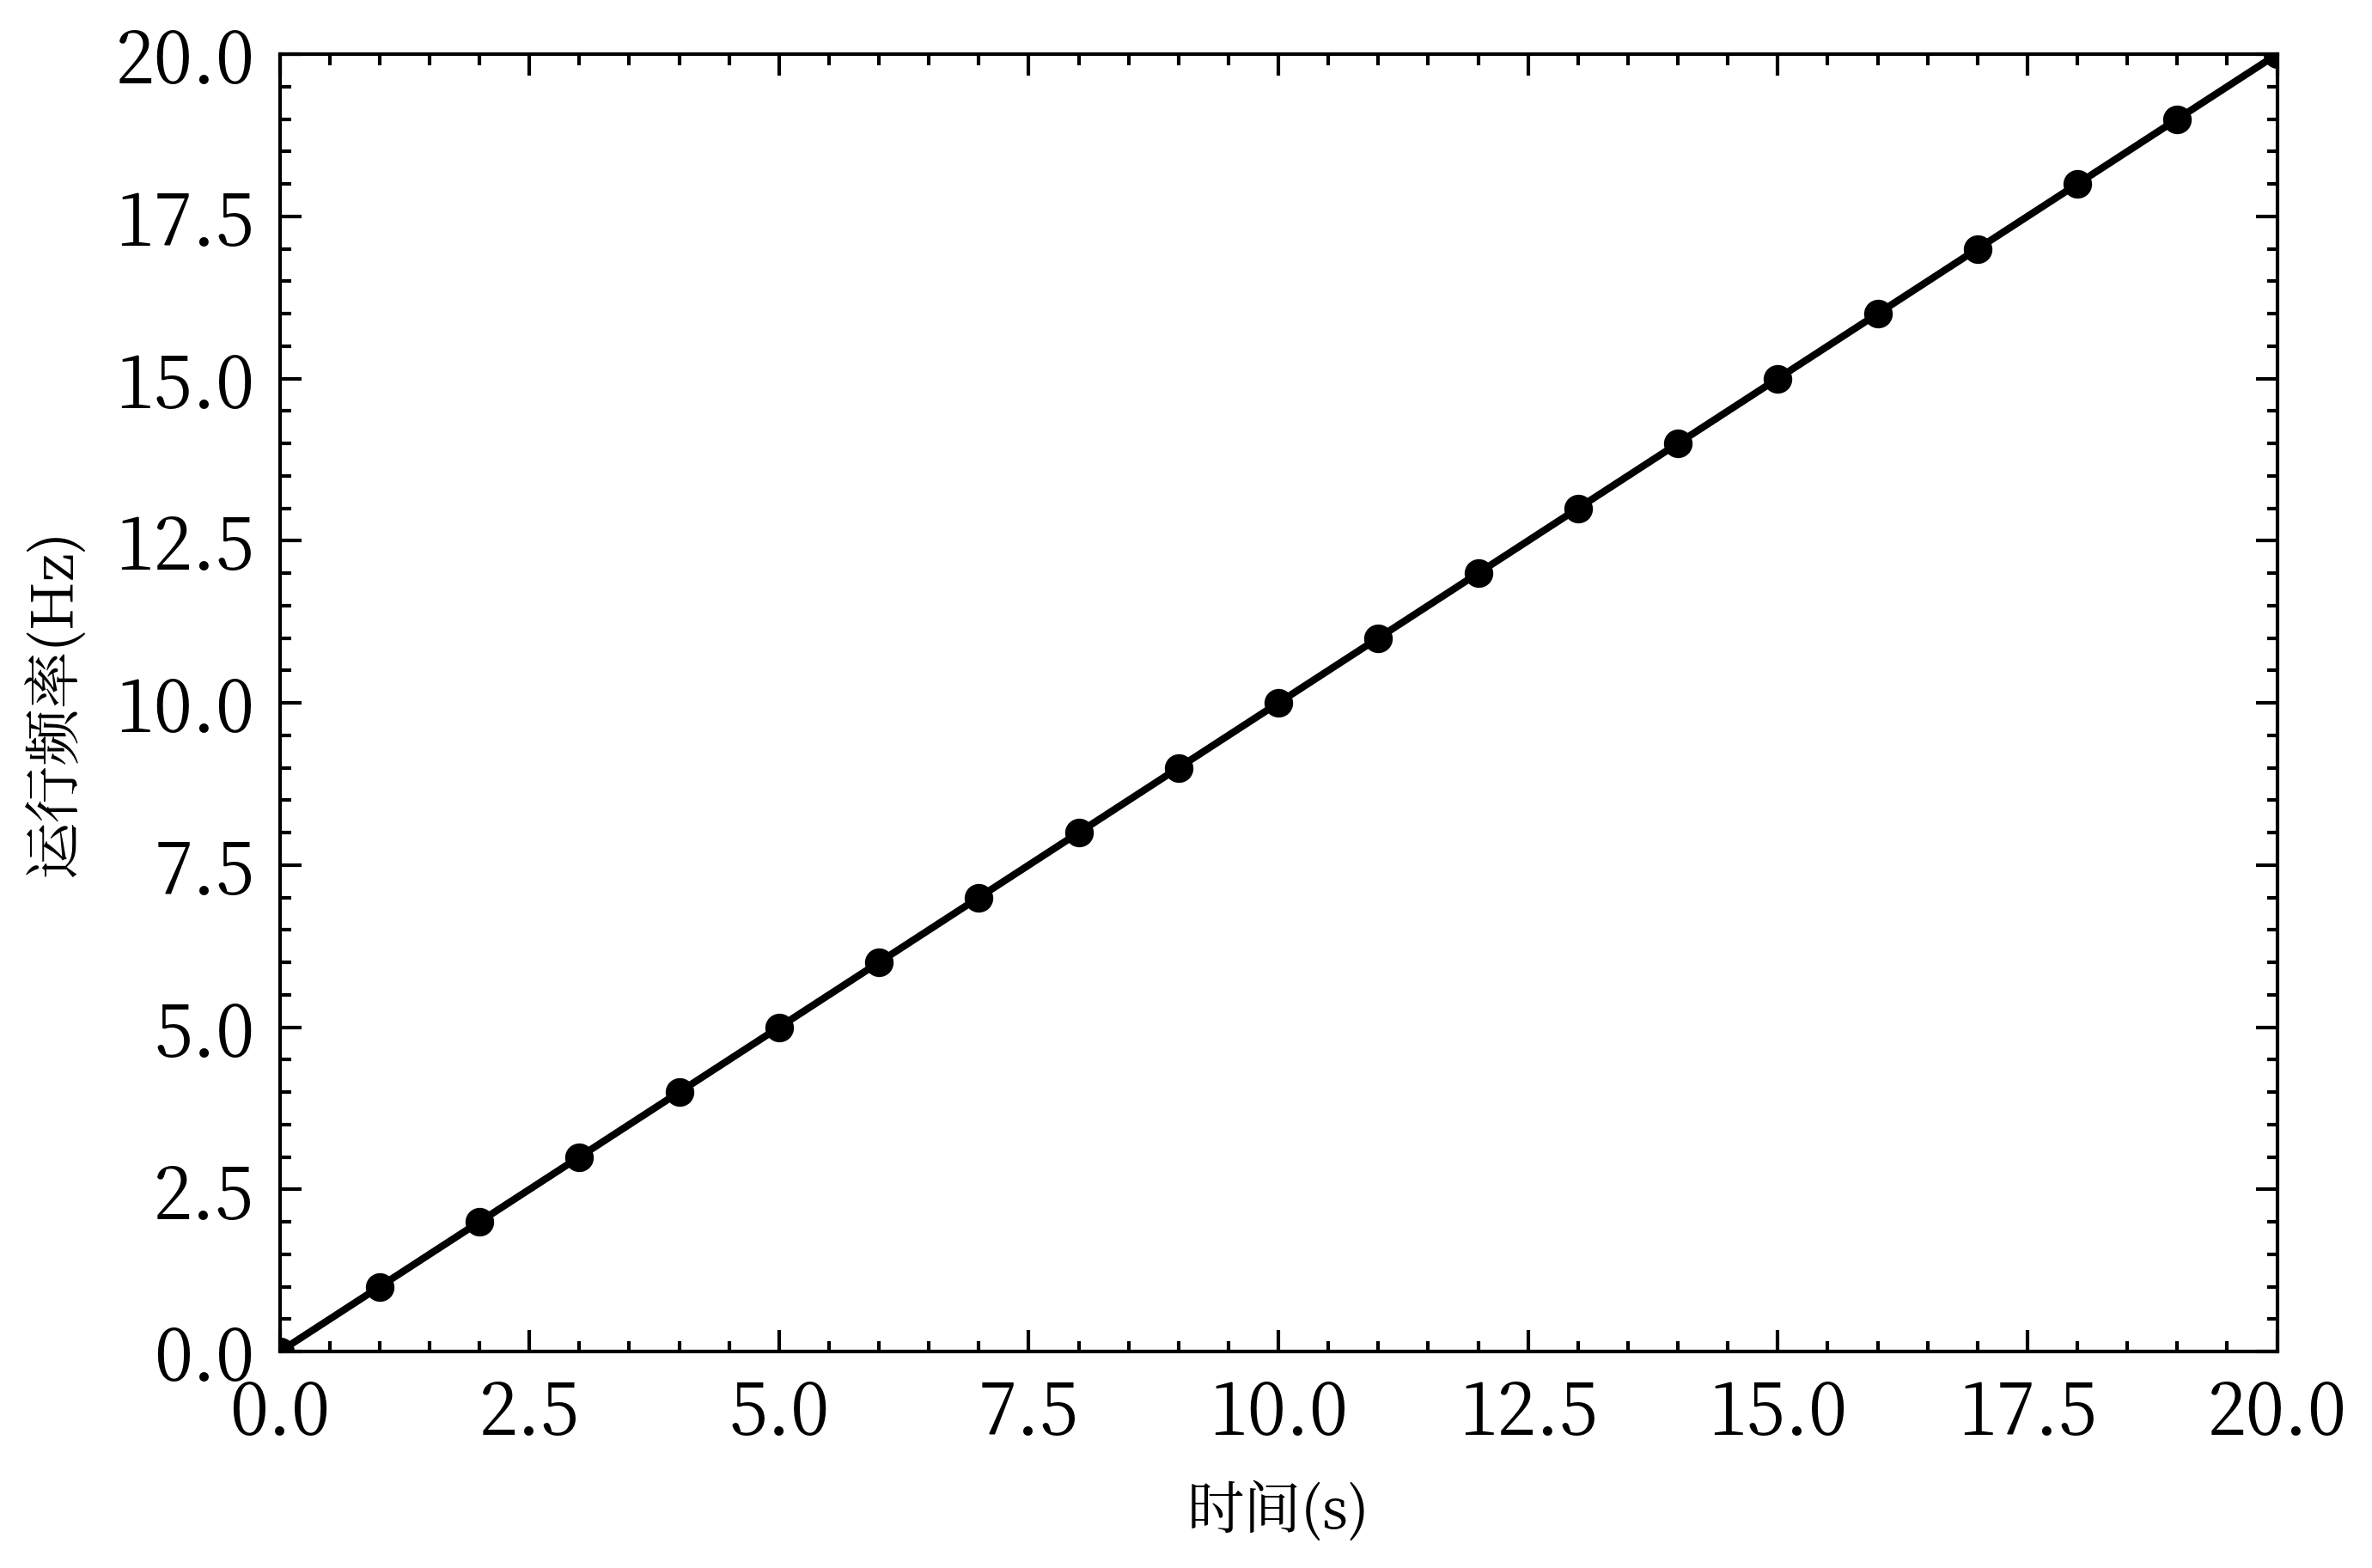

In [50]:
speedFilePath = Path("D:\datasets\复合故障数据集\工况设置\CLTC.mat")
data = scio.loadmat(speedFilePath)
data = data['CLTC_P']

x = np.arange(0, 21)
y = np.arange(0, 21)

fig, ax = plt.subplots(1, 1, figsize=(6 / 1.2, 4 / 1.2), dpi=600)
ax.plot(x, y, '.-', linewidth=1, color='black')
# 设置x、y轴标签
ax.set_ylabel("运行频率(Hz)")
ax.set_xlabel("时间(s)")
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
plt.savefig('figs/speed.png', dpi=300, bbox_inches='tight',
            pad_inches=0, transparent=True)

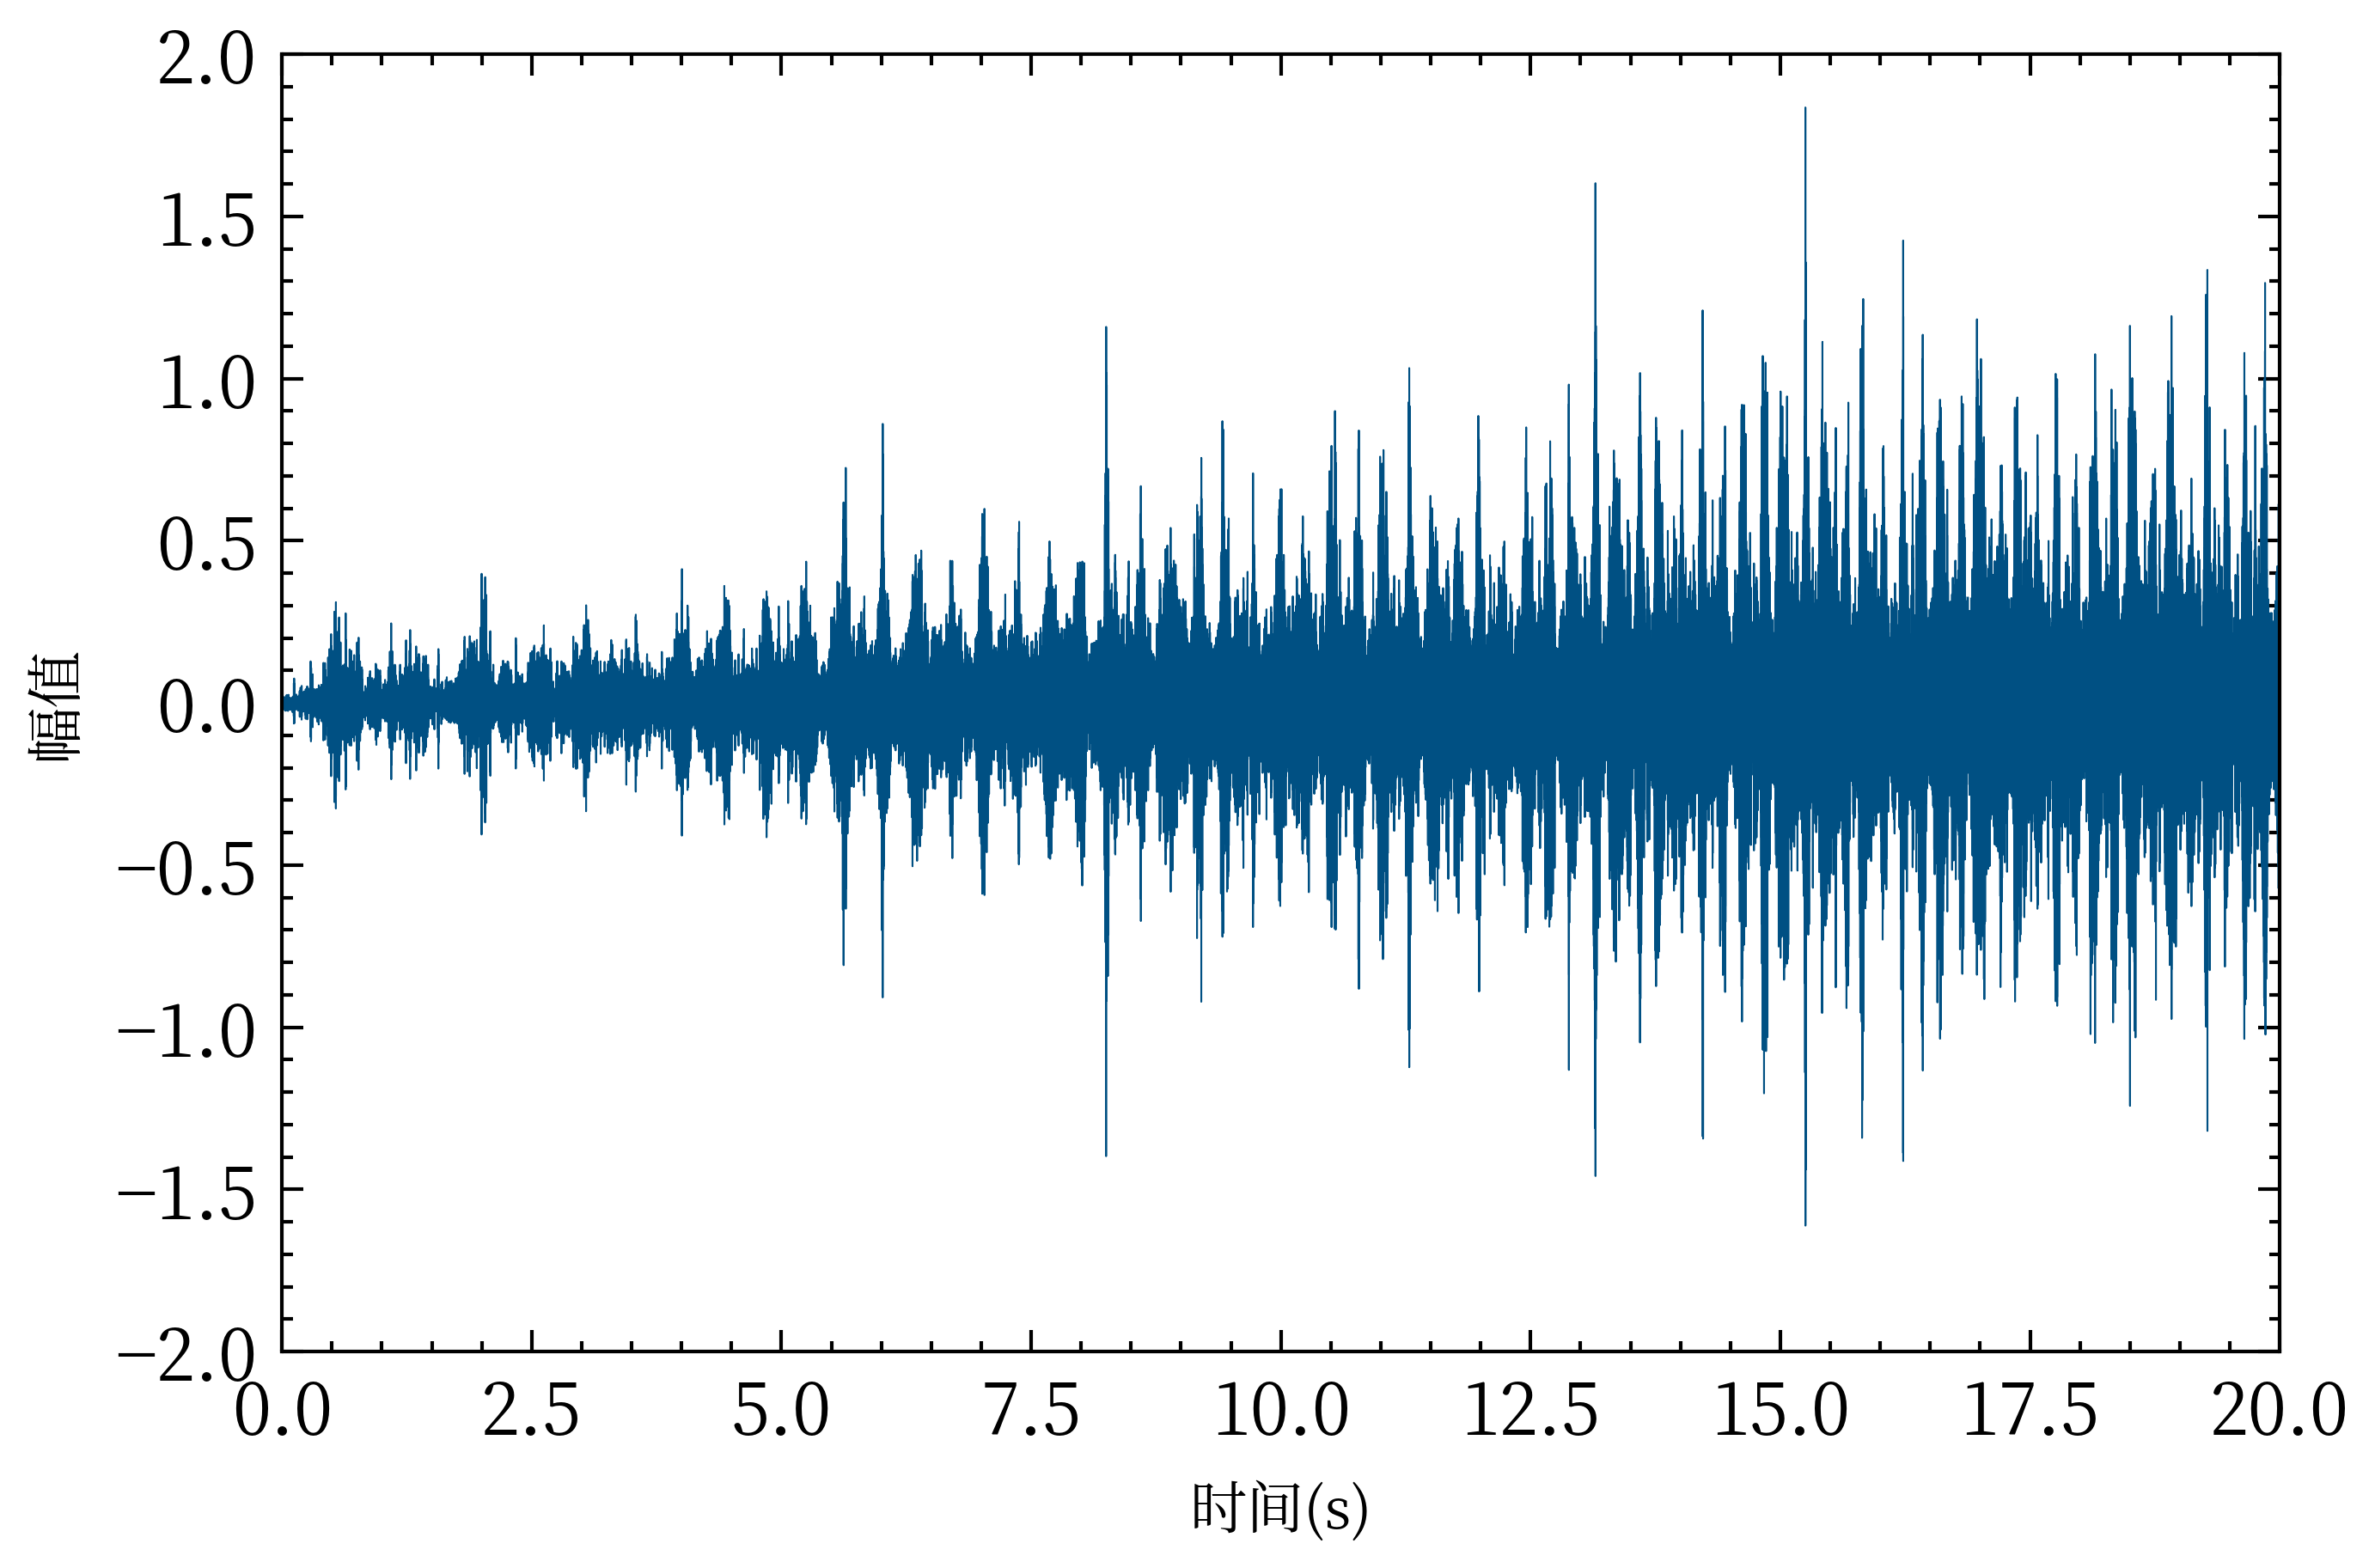

In [6]:


# fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=False)
# ax[0].plot(np.arange(0, len(sig)), sig)
# fre, amp = FFT.fft(sig, sampling_frequency)
# ax[1].plot(fre, amp)
# f, t, Zxx = signal.stft(sig, sampling_frequency, window='tukey', nperseg=nperseg, noverlap=noverlap)
# newF = interp2d(t, f, np.abs(Zxx), kind='linear')
# t_new = np.linspace(0, 1 / sampling_frequency * 5120, num=x_len)
# f_new = np.linspace(0, sampling_frequency // 2, num=f_len)
# Z_new = newF(t_new, f_new)
# Xn, Yn = np.meshgrid(t_new, f_new)
# ax[2].pcolormesh(Xn, Yn, Z_new, shading='auto')
# ax[2].axis('off')

fig, ax = plt.subplots(1, 1, figsize=(6 / 1.2, 4 / 1.2), dpi=600)

ax.plot(np.arange(0, len(sig)) / 5120, sig, color=(0, 80 / 255, 131 / 255), linewidth=0.25)

# change xlim to set_xlim
ax.set_xlim(0, len(sig) / 5120)
ax.set_ylim(-2, 2)
ax.set_xlabel('时间(s)')
ax.set_ylabel('幅值')
# plt.axis('off')
plt.savefig('figs/varied_signal.png', dpi=300, bbox_inches='tight',
            pad_inches=0, transparent=True)

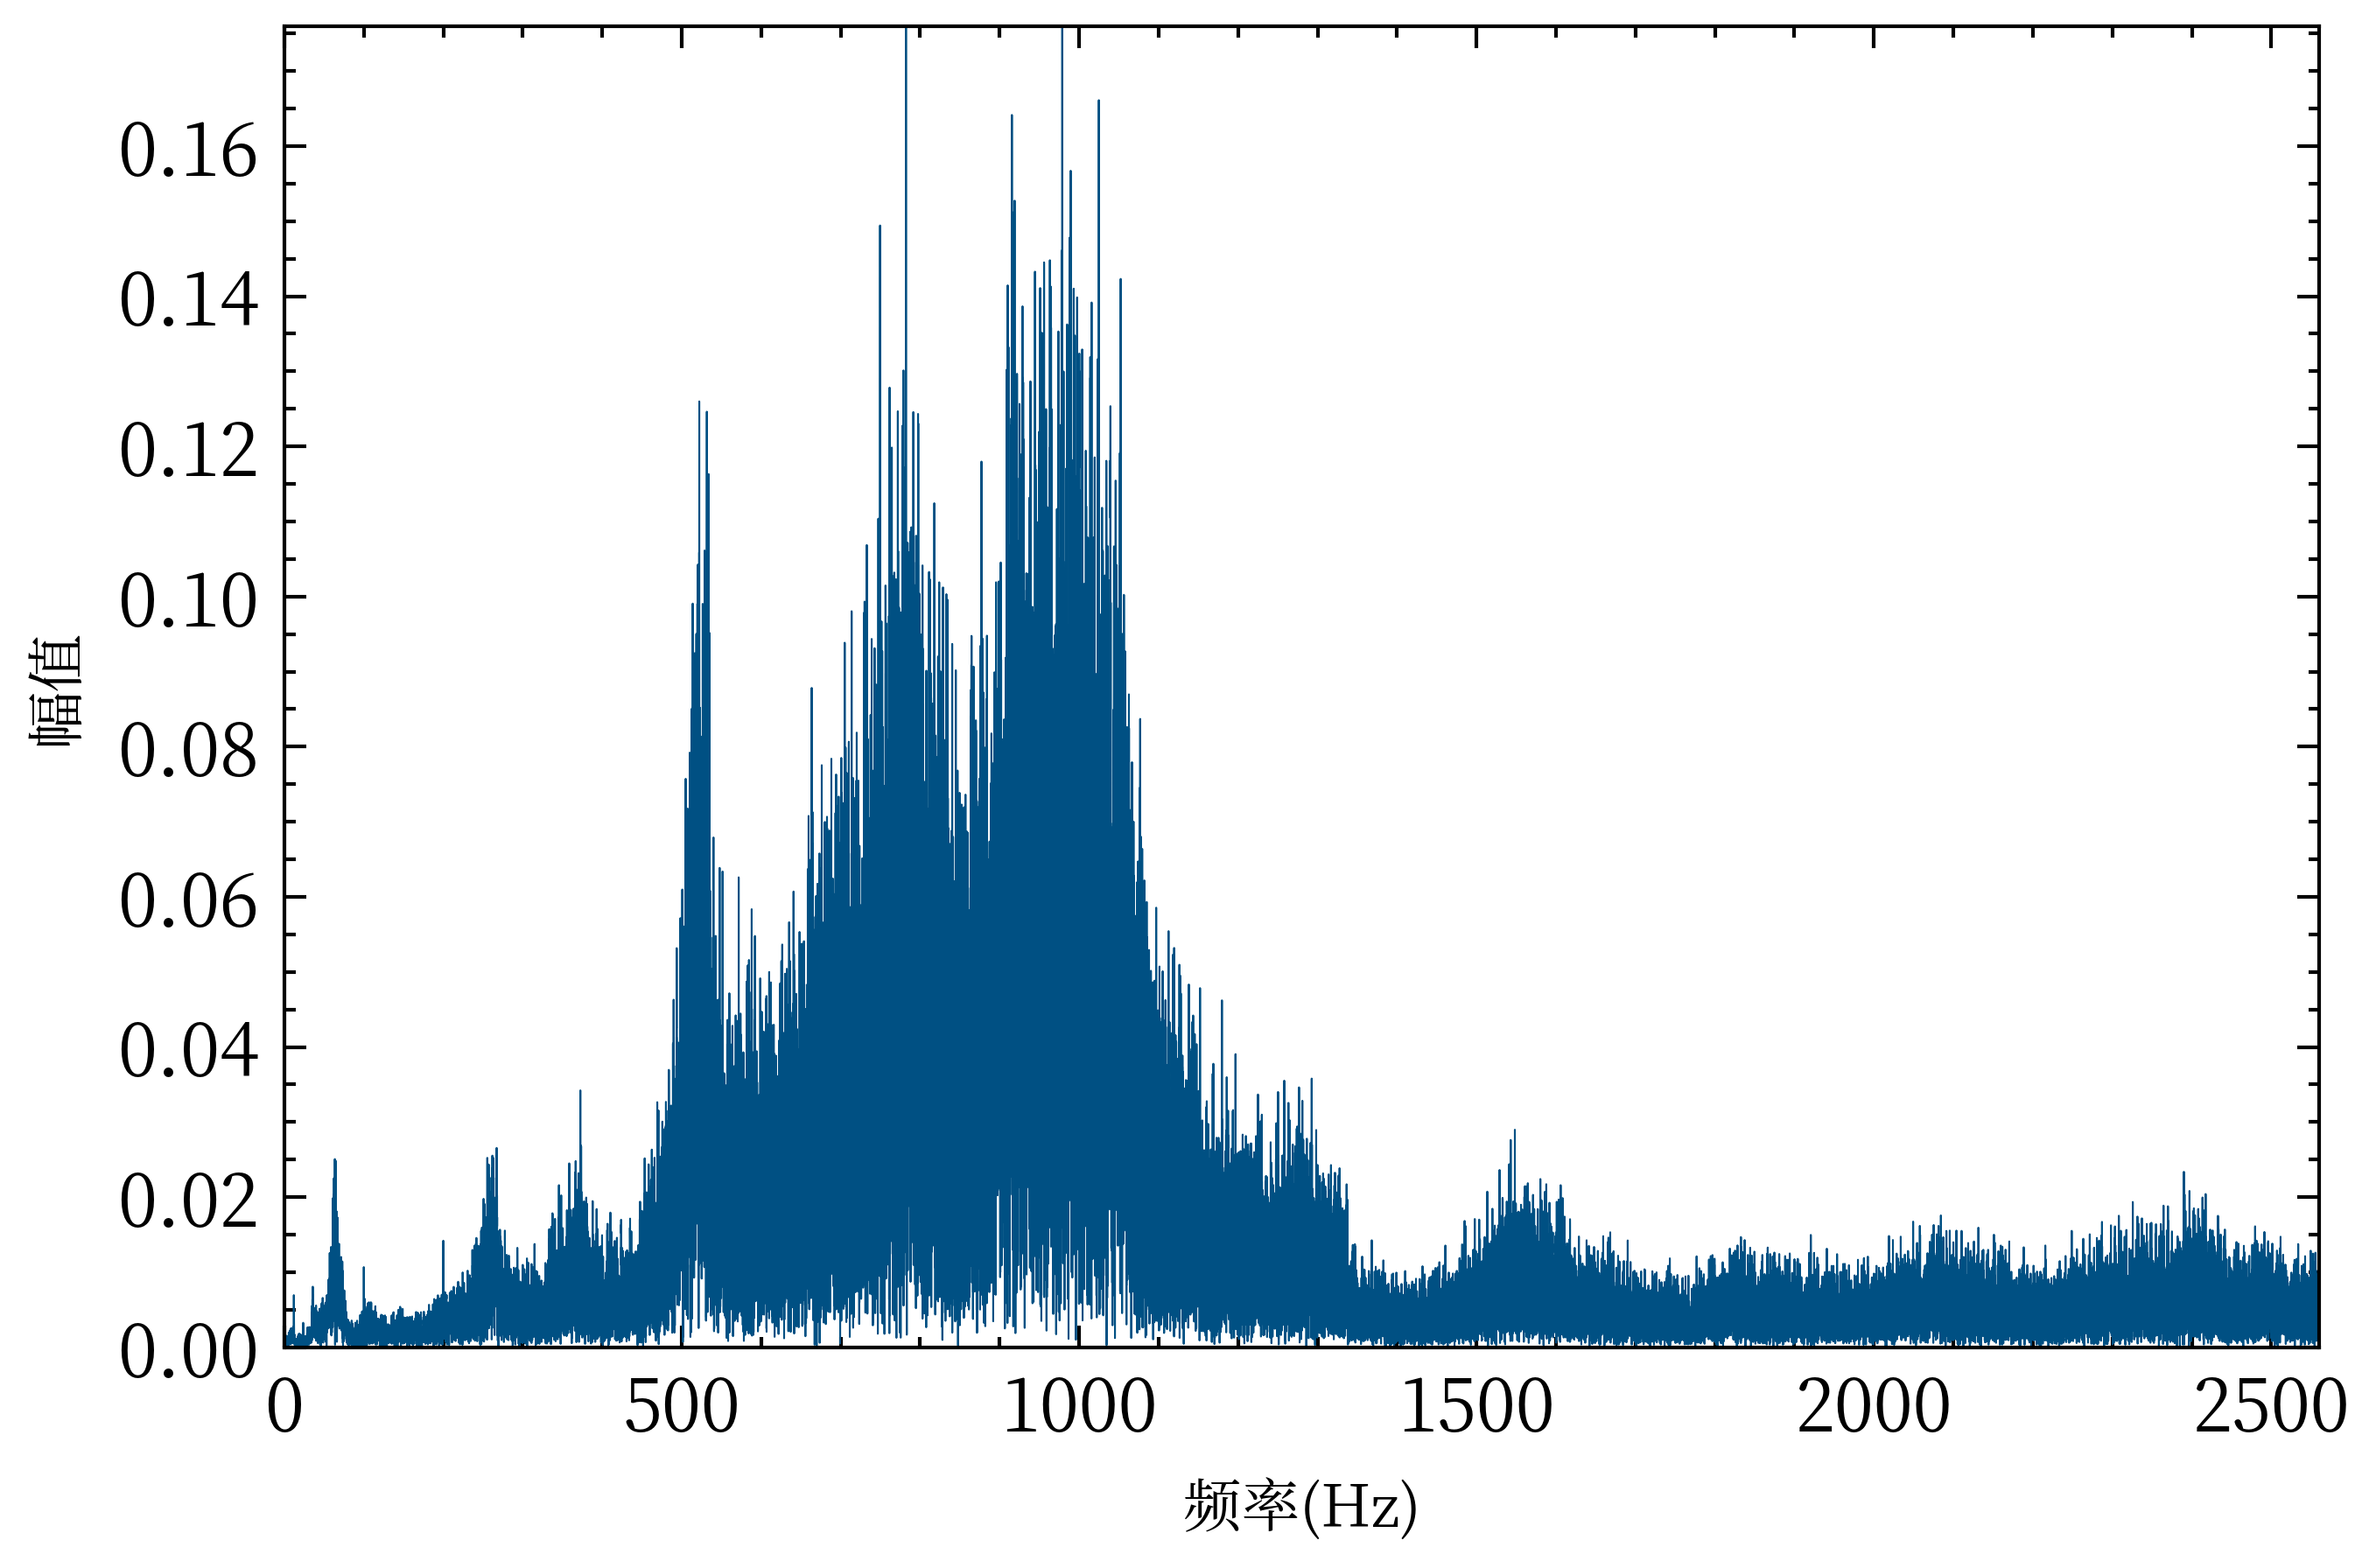

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(6 / 1.2, 4 / 1.2), dpi=600)
fre, amp = FFT.fft(sig, sampling_frequency)
ax.plot(fre, amp, color=(0, 80 / 255, 131 / 255), linewidth=0.25)
ax.set_xlabel('频率(Hz)')
ax.set_ylabel('幅值')
# change xlim to set_xlim
ax.set_xlim(0, 5120 / 2)
ax.set_ylim(0, 0.176)
plt.savefig('figs/varied_signal_fft.png', dpi=300, bbox_inches='tight',
            pad_inches=0, transparent=True)

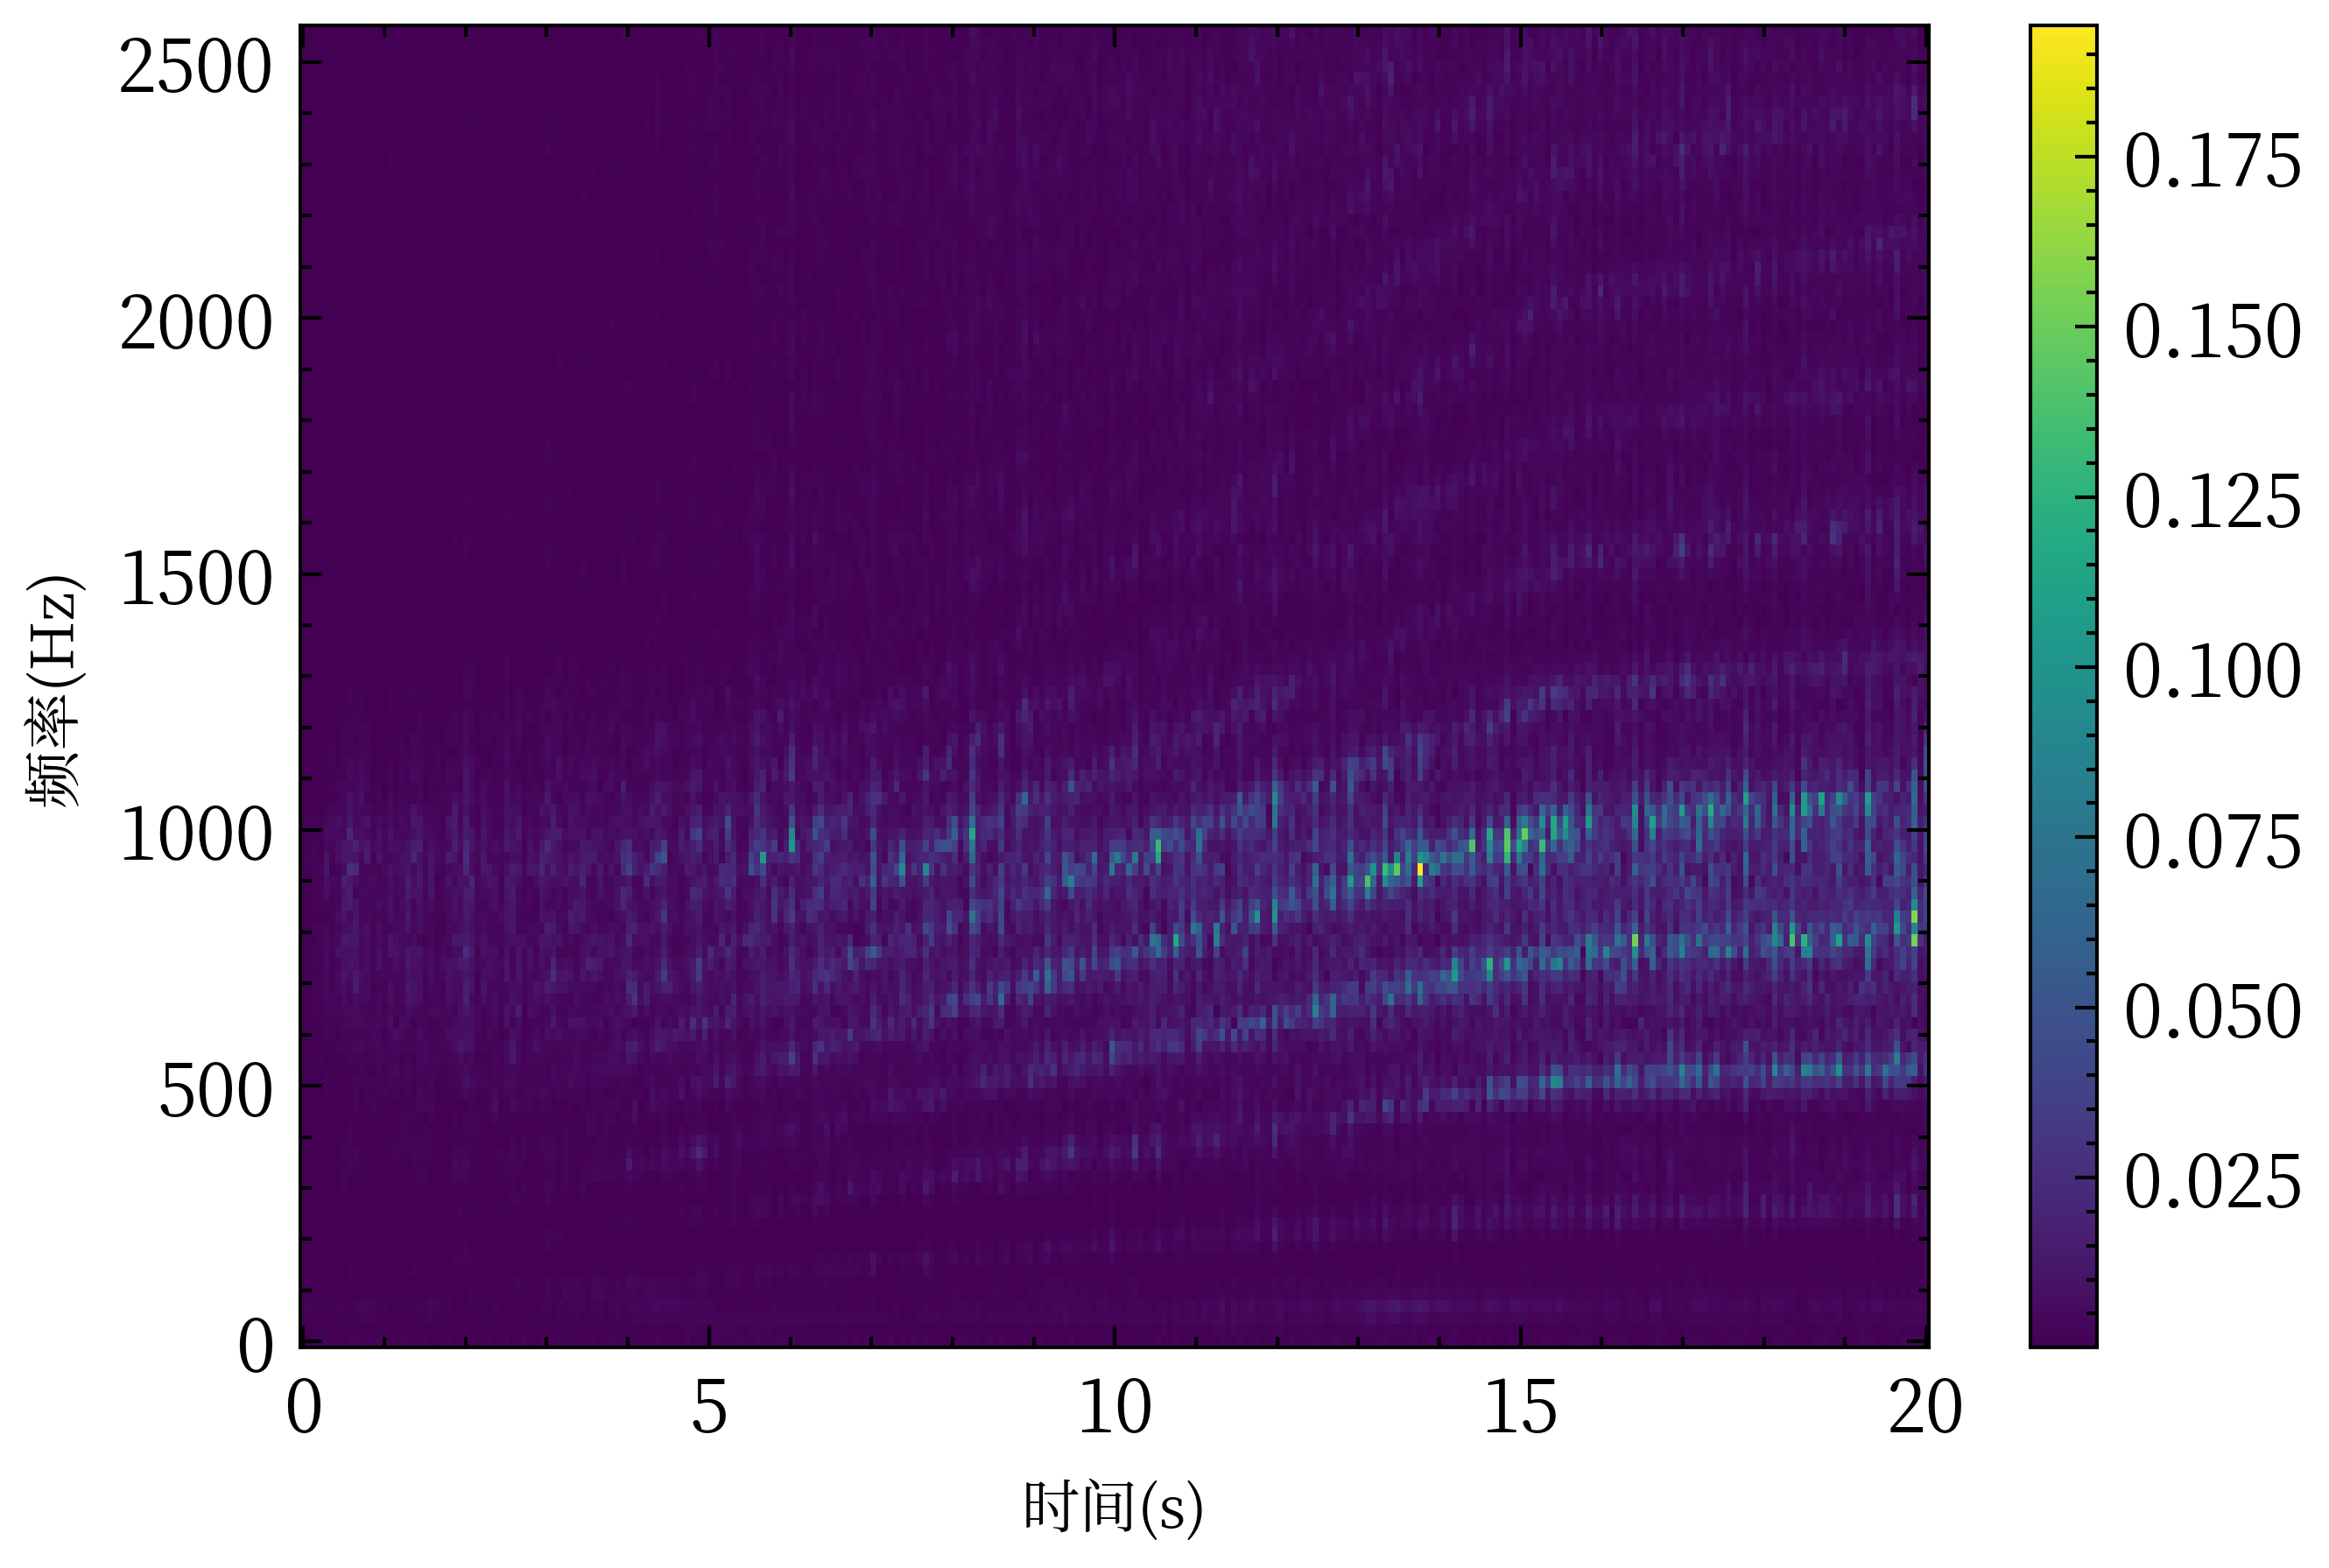

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6 / 1.2, 4 / 1.2), dpi=600)

pic_size = 56
x_len = pic_size * 5
f_len = pic_size * 2
f, t, Zxx = signal.stft(sig, sampling_frequency, window='tukey', nperseg=nperseg, noverlap=noverlap)
newF = interp2d(t, f, np.abs(Zxx), kind='linear')
t_new = np.linspace(0, 1 / sampling_frequency * 5120 * 20, num=x_len)
f_new = np.linspace(0, sampling_frequency // 2, num=f_len)
Z_new = newF(t_new, f_new)
Xn, Yn = np.meshgrid(t_new, f_new)
im = ax.pcolormesh(Xn, Yn, Z_new, shading='auto')
ax.set_xlabel('时间(s)')
ax.set_ylabel('频率(Hz)')
fig.colorbar(im)
plt.savefig('figs/varied_signal_stft.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)